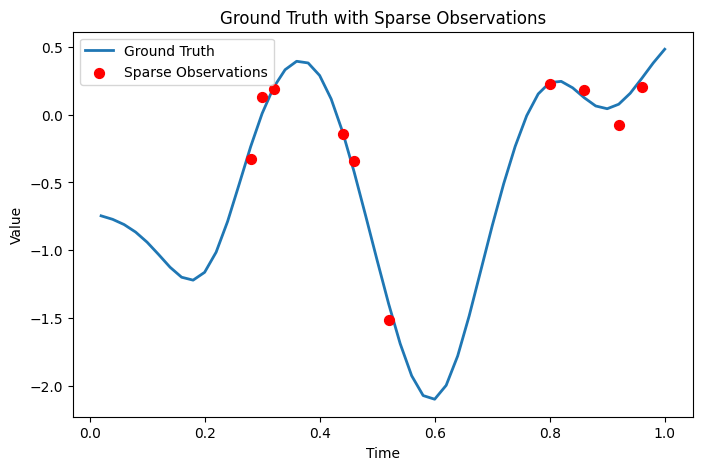

In [10]:
import matplotlib.pyplot as plt
import dataset
# Instantiate the synthetic dataset with 2000 trajectories.
data = dataset.SyntheticDataset(n=100, alpha=120.0,num_obs=10, noise_std=0.1, seed=0)

# Select a sample from the dataset (e.g., the first sample)
index = 2
sample = data[index]
dense_positions = sample["dense_positions"].numpy()
ground_truth = sample["ground_truth"].numpy()
sparse_positions = sample["sparse_positions"].numpy()
sparse_values = sample["sparse_values"].numpy()

plt.figure(figsize=(8, 5))
plt.plot(dense_positions, ground_truth, label="Ground Truth", linewidth=2)  # plot dense curve
plt.scatter(sparse_positions, sparse_values, color='red', label="Sparse Observations", s=50, zorder=5)  # scatter sparse points
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Ground Truth with Sparse Observations")
plt.legend()
plt.show()
